# CVE- Common Vulnerabilities and Exposures
cve data extracted into MongoDB using cve-search - https://github.com/cve-search/cve-search

* The extracted data from MongoDB is analyzed in this notebook

## Importing Libraries

In [1]:
#Basic Libararies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle, islice
import string
import re

#Tensorflow, sklearn and nltk
import tensorflow as tf
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
#!pip install unidecode
import unidecode
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tensorflow.keras.layers import TextVectorization
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, Dropout, MaxPool2D, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.layers import GlobalAvgPool1D, GlobalMaxPool1D
from sklearn.model_selection import train_test_split
#!pip install tensorflow-addons
#import tensorflow_addons as tfa

#WordCloud
from wordcloud import WordCloud

#gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#Spacy
import spacy

#Vis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

#warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\karth\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Connecting to MongoDB

In [4]:
# importing the required libraries
import pymongo
import pprint
import json

# connect to the mongoclient
client = pymongo.MongoClient('mongodb://localhost:27017')

# get the database
db = client['cvedb']

collection = db.get_collection('cves')

## Loading Data

In [5]:
import pandas as pd

#cursor = collection.find()
companies = ['intel', 'amd', 'broadcom', 'qualcomm', 'nxp', \
             'marvell', 'cisco', 'dell', 'hp', 'supermicro', 'hive', 'gigabyte'] 
cursor = collection.find( { "vendors" : { "$in": companies} } )

allitems_df = pd.DataFrame(list(cursor))
#allitems_df.to_csv('pymongo-allitems.csv')

#allitems_df.to_csv("selected-vendors_cves.csv")

allitems_df.head(5)

,_id,id,assigner,Published,Modified,last-modified,summary,access,impact,cvss3,...,products,vulnerable_product_stems,vulnerable_configuration_stems,cwe,vulnerable_configuration_cpe_2_2,impact3,exploitability3,cvss3-vector,impactScore3,exploitabilityScore3
0,6211d7d99483e1ad8de34b6e,CVE-2007-4315,cve@mitre.org,2007-08-13 21:17:00,2012-10-18 04:00:00,2012-10-18 04:00:00,The AMD ATI atidsmxx.sys 3.0.502.0 driver on W...,"{'authentication': 'NONE', 'complexity': 'MEDI...","{'availability': 'COMPLETE', 'confidentiality'...",NaN,...,[catalyst_driver],"[cpe:2.3:a:ati:catalyst_driver, cpe:2.3:a:amd:...","[cpe:2.3:a:ati:catalyst_driver, cpe:2.3:a:amd:...",CWE-264,[],NaN,NaN,NaN,NaN,NaN
1,6211d80dd434913254e356ee,CVE-2020-12138,cve@mitre.org,2020-04-27 15:15:00,2021-07-21 11:39:00,2021-07-21 11:39:00,AMD ATI atillk64.sys 5.11.9.0 allows low-privi...,"{'authentication': 'SINGLE', 'complexity': 'LO...","{'availability': 'COMPLETE', 'confidentiality'...",8.8,...,[atillk64],[cpe:2.3:a:amd:atillk64],[cpe:2.3:a:amd:atillk64],CWE-862,[],"{'availability': 'HIGH', 'confidentiality': 'H...","{'attackvector': 'NETWORK', 'attackcomplexity'...",CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,5.9,2.8
2,6211d80f9483e1ad8de356a5,CVE-2020-12892,psirt@amd.com,2021-11-15 19:15:00,2021-11-18 16:06:00,2021-11-18 16:06:00,An untrusted search path in AMD Radeon setting...,"{'authentication': 'NONE', 'complexity': 'MEDI...","{'availability': 'PARTIAL', 'confidentiality':...",7.8,...,[radeon_software],[cpe:2.3:a:amd:radeon_software],"[cpe:2.3:a:amd:radeon_software, cpe:2.3:o:micr...",CWE-426,[],"{'availability': 'HIGH', 'confidentiality': 'H...","{'attackvector': 'LOCAL', 'attackcomplexity': ...",CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,5.9,1.8
3,6211d80f9483e1ad8de356aa,CVE-2020-12900,psirt@amd.com,2021-11-15 16:15:00,2021-11-18 03:36:00,2021-11-18 03:36:00,An arbitrary write vulnerability in the AMD Ra...,"{'authentication': 'NONE', 'complexity': 'LOW'...","{'availability': 'PARTIAL', 'confidentiality':...",7.8,...,[radeon_software],[cpe:2.3:a:amd:radeon_software],"[cpe:2.3:a:amd:radeon_software, cpe:2.3:o:micr...",CWE-269,[],"{'availability': 'HIGH', 'confidentiality': 'H...","{'attackvector': 'LOCAL', 'attackcomplexity': ...",CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,5.9,1.8
4,6211d80f9483e1ad8de356b4,CVE-2020-12920,psirt@amd.com,2021-11-15 16:15:00,2021-11-18 03:24:00,2021-11-18 03:24:00,A potential denial of service issue exists in ...,"{'authentication': 'NONE', 'complexity': 'LOW'...","{'availability': 'PARTIAL', 'confidentiality':...",5.5,...,[radeon_software],[cpe:2.3:a:amd:radeon_software],[cpe:2.3:a:amd:radeon_software],NVD-CWE-noinfo,[],"{'availability': 'HIGH', 'confidentiality': 'N...","{'attackvector': 'LOCAL', 'attackcomplexity': ...",CVSS:3.1/AV:L/AC:L/PR:L/UI:N/S:U/C:N/I:N/A:H,3.6,1.8


## Data Cleaning and Validation

In [6]:
allitems_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10772 entries, 0 to 10771
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   _id                               10772 non-null  object        
 1   id                                10772 non-null  object        
 2   assigner                          10772 non-null  object        
 3   Published                         10772 non-null  datetime64[ns]
 4   Modified                          10772 non-null  datetime64[ns]
 5   last-modified                     10772 non-null  datetime64[ns]
 6   summary                           10772 non-null  object        
 7   access                            10772 non-null  object        
 8   impact                            10772 non-null  object        
 9   cvss3                             6722 non-null   float64       
 10  cvss                              10772 non-nu

In [7]:
allitems_df.isna().sum()

_id                                    0
id                                     0
assigner                               0
Published                              0
Modified                               0
last-modified                          0
summary                                0
access                                 0
impact                                 0
cvss3                               4050
cvss                                   0
exploitabilityScore                    0
impactScore                            0
cvss-time                              0
cvss-vector                            0
references                             0
vulnerable_configuration               0
vulnerable_product                     0
vendors                                0
products                               0
vulnerable_product_stems               0
vulnerable_configuration_stems         0
cwe                                    0
vulnerable_configuration_cpe_2_2       0
impact3         

In [8]:
# Checking if duplicates are there by cve_id (id column)
print(~len(allitems_df.id.drop_duplicates())==len(allitems_df))
print("So, there are no duplicate columns")

False
So, there are no duplicate columns


In [9]:
# Checking if both columns are one and the same
print((allitems_df['last-modified']==allitems_df['Modified']).all())
print("So, Last modified and modified are basically same columns indicating the latest date the cve record got updated")

True
So, Last modified and modified are basically same columns indicating the latest date the cve record got updated


In [10]:
#Sample values of column impact
allitems_df.impact.sample(5).values

array([{'availability': 'NONE', 'confidentiality': 'NONE', 'integrity': 'PARTIAL'},
       {'availability': 'NONE', 'confidentiality': 'NONE', 'integrity': 'PARTIAL'},
       {'availability': 'COMPLETE', 'confidentiality': 'NONE', 'integrity': 'NONE'},
       {'availability': 'PARTIAL', 'confidentiality': 'PARTIAL', 'integrity': 'NONE'},
       {'availability': 'COMPLETE', 'confidentiality': 'COMPLETE', 'integrity': 'COMPLETE'}],
      dtype=object)

In [11]:
#Sample values of column access
allitems_df.access.sample(5).values

array([{'authentication': 'NONE', 'complexity': 'MEDIUM', 'vector': 'NETWORK'},
       {'authentication': 'SINGLE', 'complexity': 'LOW', 'vector': 'NETWORK'},
       {'authentication': 'NONE', 'complexity': 'MEDIUM', 'vector': 'LOCAL'},
       {'authentication': 'NONE', 'complexity': 'LOW', 'vector': 'NETWORK'},
       {'authentication': 'NONE', 'complexity': 'LOW', 'vector': 'NETWORK'}],
      dtype=object)

## EDA

### Products

Number of records corresponding to products more than one:	 4311


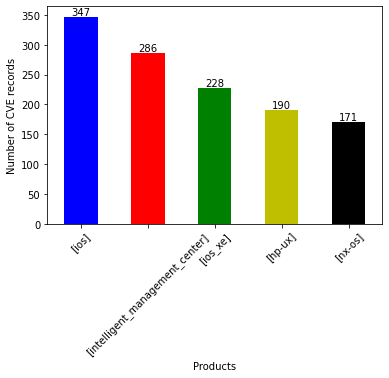

In [79]:
c=0
for i in range(len(allitems_df)):
    if len(allitems_df.products[i])>1:
        #print(allitems_df.vendors[i])
        c+=1

print("Number of records corresponding to products more than one:\t",c)

p = allitems_df.products.value_counts()[:5]

def plot_bar(p, my_colors=list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(p))) ):
    ax = p.plot.bar(color=my_colors)
    for container in ax.containers:
        ax.bar_label(container)
    return ax

ax = plot_bar(p)
plt.xlabel('Products')
plt.xticks(rotation = 45)
plt.ylabel('Number of CVE records')
plt.show()

### Vendors

Number of records relating to vendors more than one:	 483


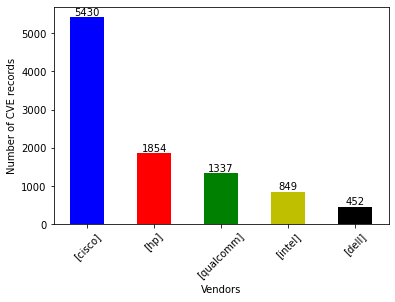

In [80]:
c=0
for i in range(len(allitems_df)):
    if len(allitems_df.vendors[i])>1:
        #print(allitems_df.vendors[i])
        c+=1

print("Number of records relating to vendors more than one:\t",c)

p = allitems_df.vendors.value_counts()[:5]
ax = plot_bar(p)
plt.xlabel('Vendors')
plt.xticks(rotation = 45)
plt.ylabel('Number of CVE records')
plt.show()

### Assigners

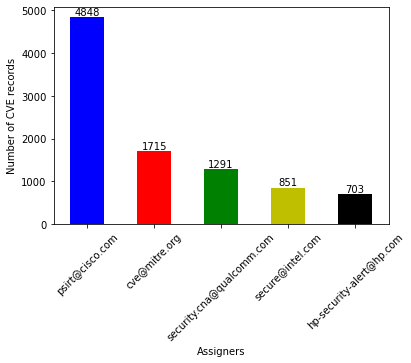

Total number of unique assigners of cve records available:	 35


In [81]:
p = allitems_df.assigner.value_counts()[:5]

ax = plot_bar(p)
plt.xlabel('Assigners')
plt.xticks(rotation = 45)
plt.ylabel('Number of CVE records')
plt.show()
    
print("Total number of unique assigners of cve records available:\t",len(allitems_df.assigner.unique()))

### Summary or description of the CVE in Wordcloud

Maximum summary/description of a cve record available is 2649


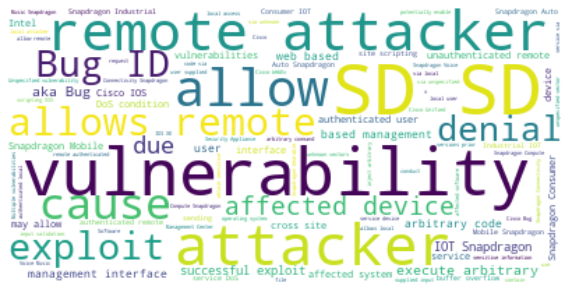

In [82]:
print('Maximum summary/description of a cve record available is',\
      np.vectorize(len)(allitems_df.summary.values.astype(str)).max(axis=0))

def word_cloud(text,
               max_font_size=50,
               max_words=100,
               background_color='white', 
               figsize=(10,10),  
               interpolation="bilinear"):
    wc = WordCloud(max_font_size=max_font_size, max_words=max_words, background_color=background_color).generate(text)
    plt.figure(figsize=figsize)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

text = ' '.join(allitems_df.summary.values)
word_cloud(text)

## Data Preparation

In [12]:
# Selecting a particular vendor ex. cisco
# cisco_df = allitems_df.loc[allitems_df.vendors.str[0].str.contains("cisco"), :].reset_index()
final_df = allitems_df.copy()

In [13]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)


lemmatized_texts = lemmatization(final_df.summary)
print (lemmatized_texts[0][0:90])

driver allow local user bypass driver signing policy write arbitrary kernel memory locatio


In [14]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words = gen_words(lemmatized_texts)

print (data_words[0][0:20])

['driver', 'allow', 'local', 'user', 'bypass', 'driver', 'signing', 'policy', 'write', 'arbitrary', 'kernel', 'memory', 'location', 'thereby', 'gain', 'privilege', 'unspecified', 'vector', 'demonstrate']


In [15]:
id2word = corpora.Dictionary(data_words)

corpus = []
for text in data_words:
    new = id2word.doc2bow(text)
    corpus.append(new)

print (new[0][0:20])

word = id2word[[0][:1][0]]
print (word)

(0, 1)
allow


## LDA Model

In [16]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2,
                                           random_state=100,
                                           update_every=10,
                                           chunksize=1000,
                                           passes=50,
                                           iterations = 100,
                                           alpha="auto")

In [17]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=50)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
1     -0.001778 -0.031383       1        1  87.10333
0      0.001778  0.031383       2        1  12.89667, topic_info=              Term         Freq        Total Category  logprob  loglift
50   vulnerability  7302.000000  7302.000000  Default  50.0000  50.0000
68          device  3537.000000  3537.000000  Default  49.0000  49.0000
732       affected  2790.000000  2790.000000  Default  48.0000  48.0000
51        attacker  7312.000000  7312.000000  Default  47.0000  47.0000
15            user  3548.000000  3548.000000  Default  46.0000  46.0000
..             ...          ...          ...      ...      ...      ...
174       overflow   139.153747  2523.469127   Topic2  -5.4816  -0.8496
9           memory   130.581981  2016.293585   Topic2  -5.5452  -0.6888
361          early   124.146101  1641.521561   Topic2  -5.5958  -0.5337
11       privilege   117.609120  1420.524857   Topic2  -5.6499  -0.4432
341         buffer   124.955706  3511.586346   Topic2  -5.5893  -1.2877

[308 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
269       1  0.513379      abort
269       2  0.513379      abort
61        1  0.913591     access
61        2  0.086395     access
19        1  0.810478    address
...     ...       ...        ...
325       2  0.143208        web
2920      1  0.325601  whitelist
2920      2  0.651201  whitelist
913       1  0.949765      wrong
913       2  0.045772      wrong

[438 rows x 3 columns], R=50, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [18]:
lda_model.print_topics()

[(0,
  '0.038*"vulnerability" + 0.022*"attacker" + 0.022*"device" + 0.021*"sd" + 0.018*"allow" + 0.018*"affected" + 0.018*"user" + 0.017*"cause" + 0.014*"service" + 0.013*"remote"'),
 (1,
  '0.065*"sd" + 0.029*"attacker" + 0.028*"allow" + 0.027*"vulnerability" + 0.016*"remote" + 0.015*"buffer" + 0.013*"user" + 0.013*"exploit" + 0.013*"access" + 0.012*"device"')]

In [19]:
print("\nPerplexity:\t",lda_model.log_perplexity(corpus, total_docs=10000),'\n')

coherence_model_lda = CoherenceModel(model=lda_model, texts=final_df.summary, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print("\nCoherence Score:\t",coherence_lda,'\n')


Perplexity:	 -5.9203421088504475 


Coherence Score:	 nan 

